# Unit 7.4: Exercise 1

## Training a Resnet-52 on mini-ImageNet

- Loading a model from the PyTorch Hub: https://pytorch.org/docs/stable/hub.html

I will load RestNet50 just because I'm using the mini ImageNet dataset instead

In [1]:
import torch

entrypoints = torch.hub.list('pytorch/vision', force_reload=True)
for e in entrypoints:
    print(e)

Downloading: "https://github.com/pytorch/vision/zipball/main" to /Users/lancho/.cache/torch/hub/main.zip
/Users/lancho/.cache/torch/hub/pytorch_vision_main/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: ''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/opt/homebrew/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


alexnet
convnext_base
convnext_large
convnext_small
convnext_tiny
deeplabv3_mobilenet_v3_large
deeplabv3_resnet101
deeplabv3_resnet50
densenet121
densenet161
densenet169
densenet201
efficientnet_b0
efficientnet_b1
efficientnet_b2
efficientnet_b3
efficientnet_b4
efficientnet_b5
efficientnet_b6
efficientnet_b7
efficientnet_v2_l
efficientnet_v2_m
efficientnet_v2_s
fcn_resnet101
fcn_resnet50
get_model_weights
get_weight
googlenet
inception_v3
lraspp_mobilenet_v3_large
maxvit_t
mc3_18
mnasnet0_5
mnasnet0_75
mnasnet1_0
mnasnet1_3
mobilenet_v2
mobilenet_v3_large
mobilenet_v3_small
mvit_v1_b
mvit_v2_s
r2plus1d_18
r3d_18
raft_large
raft_small
regnet_x_16gf
regnet_x_1_6gf
regnet_x_32gf
regnet_x_3_2gf
regnet_x_400mf
regnet_x_800mf
regnet_x_8gf
regnet_y_128gf
regnet_y_16gf
regnet_y_1_6gf
regnet_y_32gf
regnet_y_3_2gf
regnet_y_400mf
regnet_y_800mf
regnet_y_8gf
resnet101
resnet152
resnet18
resnet34
resnet50
resnext101_32x8d
resnext101_64x4d
resnext50_32x4d
s3d
shufflenet_v2_x0_5
shufflenet_v2_x1_0
sh

In [2]:
%load_ext watermark
%watermark -p torch,lightning,torchvision

torch      : 2.0.1
lightning  : 2.0.5
torchvision: 0.15.2



In [3]:
import lightning as L
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt
import numpy as np

from local_utilities import LightningModel,ImageNetDataModule, plot_loss_and_acc

In [4]:
L.seed_everything(123)
dm = ImageNetDataModule(data_path='tiny-imagenet-200',batch_size=64, num_workers=4)
# dm.prepare_data()
dm.setup()

Global seed set to 123


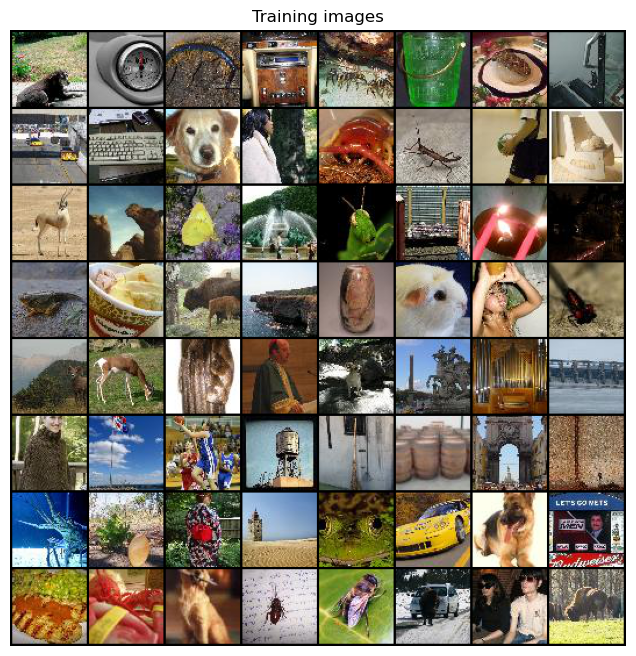

In [5]:
for images, labels in dm.train_dataloader():  
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64], 
    padding=2,
    normalize=True),
    (1, 2, 0)))
plt.show()

In [6]:
pytorch_model = torch.hub.load("pytorch/vision", "resnet50", weights='IMAGENET1K_V2')

Using cache found in /Users/lancho/.cache/torch/hub/pytorch_vision_main


In [7]:
pytorch_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
for param in pytorch_model.parameters():
    param.requires_grad = False
    
pytorch_model.fc = torch.nn.Linear(2048, 200)

In [9]:
%%capture --no-display

L.pytorch.seed_everything(123)

# dm = Cifar10DataModule(height_width=(128, 128), num_workers=4) # to make it train faster

lightning_model = LightningModel(model=pytorch_model, learning_rate=0.1)

trainer = L.Trainer(
    max_epochs=10,
    accelerator="cpu",
    devices=1,
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
)

Global seed set to 123
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
trainer.fit(model=lightning_model, datamodule=dm)


  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 23.9 M
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
409 K     Trainable params
23.5 M    Non-trainable params
23.9 M    Total params
95.671    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 1484/1484 [53:49<00:00,  2.18s/it, v_num=2, val_loss=2.460, val_acc=0.473, train_acc=0.606]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1484/1484 [53:49<00:00,  2.18s/it, v_num=2, val_loss=2.460, val_acc=0.473, train_acc=0.606]


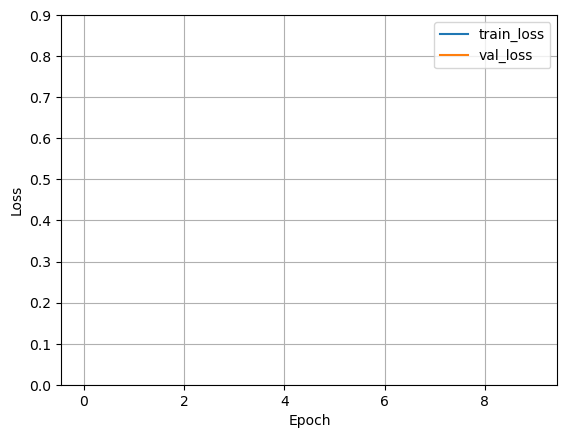

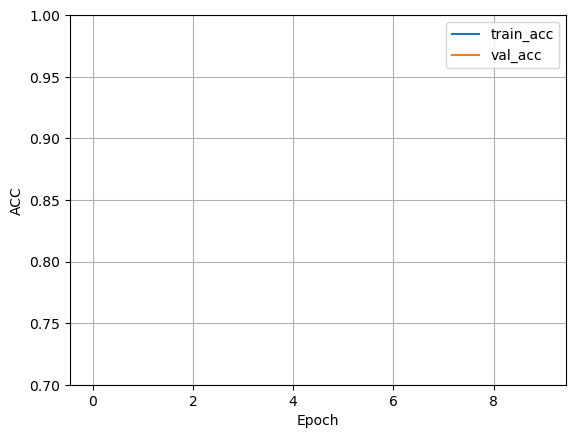

In [11]:
plot_loss_and_acc(trainer.logger.log_dir)

In [12]:
trainer.test(model=lightning_model, datamodule=dm)

Testing DataLoader 0: 100%|██████████| 157/157 [05:24<00:00,  2.06s/it]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │   0.004600000102072954    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.004600000102072954}]